## This notebook shows how to apply pseudo face parsing labels to given faces

- author: Dense-Face
- date: 02/07/2024

In [1]:
import cv2
import numpy as np 
from matplotlib import pyplot
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import tensorflow as tf

In [2]:
import alignedFaceParsingUtils

In [3]:
cmap = pyplot.get_cmap('tab20')
TAB20 = np.zeros([256, 3], dtype='uint8')
for i in range(20) :
    TAB20[i] = cmap(i, bytes=True)[:3]
    
def apply_colormap(m) :
    return TAB20[m.argmax(axis=-1)] 

In [4]:
HandFacePersonSSDONNXOpenCV = alignedFaceParsingUtils.HandFacePersonSSDONNXOpenCV
HandFacePersonCenterNetONNXOpenCV = alignedFaceParsingUtils.HandFacePersonCenterNetONNXOpenCV
NUFace3DOnnxOpenCV = alignedFaceParsingUtils.NUFace3DOnnxOpenCV
FaceAlignmentCropper = alignedFaceParsingUtils.FaceAlignmentCropper
FaceParsingTfLite = alignedFaceParsingUtils.FaceParsingTfLite

In [5]:
ssd = HandFacePersonSSDONNXOpenCV('./handfacetorso_ssd.onnx')
cnet = HandFacePersonCenterNetONNXOpenCV('./handfaceperson_centernet.onnx')
facemesh = NUFace3DOnnxOpenCV('./nuface3d_wpdc_gt.onnx')
facemask = FaceParsingTfLite('./face_parsing_f16.tflite')

face_preproc = FaceAlignmentCropper(ssd, 
                              cnet, 
                              facemesh, 
                              pad_face_perc=0., 
                              min_scale=1, 
                              max_scale=8,
                              max_num_faces=20)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


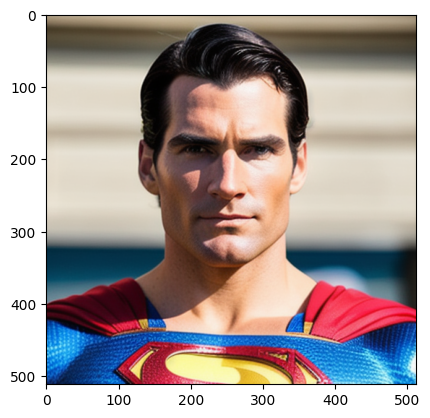

In [7]:
img_path = "../2_12_stage_4_release/output_stage_1/prompt_0_3.png"
img = cv2.cvtColor( cv2.imread(img_path), cv2.COLOR_BGR2RGB)
pyplot.imshow(img)

In [8]:
crop_list = face_preproc(img, thresh=0.3)

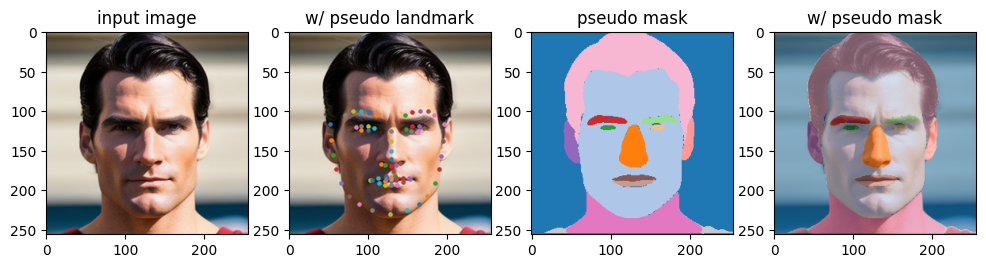

In [15]:
for crop, ann, mat in crop_list :
    pyplot.figure(figsize=(12,3))
    pyplot.subplot(141)
    pyplot.imshow(crop)
    pyplot.title('input image')
    pyplot.subplot(142)
    pyplot.imshow(crop)
    for xy in np.array(ann['lmk68']).reshape([-1,2]) :
        pyplot.scatter(*xy, s=5)
    pyplot.title('w/ pseudo landmark')
    pyplot.subplot(143)
    mask = facemask(crop, return_mask=True)
    pyplot.imshow(apply_colormap(mask))
    pyplot.title('pseudo mask')
    pyplot.subplot(144)
    pyplot.imshow(crop)
    pyplot.imshow(apply_colormap(mask), alpha=0.5)
    pyplot.title('w/ pseudo mask')
    pyplot.show()

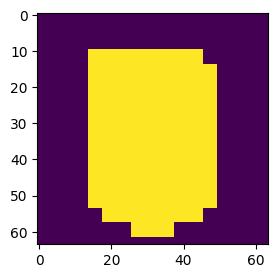

In [16]:
## naively generate mask for blending:
mask_viz = np.zeros_like(mask[:,:,1])
pyplot.figure(figsize=(3,3))
for i in range(1,7):
    mask_viz += mask[:,:,i]
mask_viz += mask[:,:,10]
mask_viz += mask[:,:,11]
mask_viz = cv2.resize(mask_viz, (16, 16))
mask_viz = cv2.resize(mask_viz, (64, 64))
mask_viz[mask_viz!=0] = 1
pyplot.imshow(mask_viz)
pyplot.show()

(64, 64)
(64, 64)


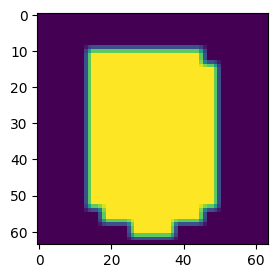

In [17]:
## create a smaller mask, that only changes the face pattern instead of face contour.
import random
mask_sample = mask_viz
print(mask_viz.shape)
kernel_1 = 3
kernel_1=(kernel_1,kernel_1)
mask_blured = cv2.GaussianBlur(mask_sample, kernel_1, 0)
print(mask_blured.shape)
pyplot.figure(figsize=(3,3))
pyplot.imshow(mask_blured)
pyplot.show()

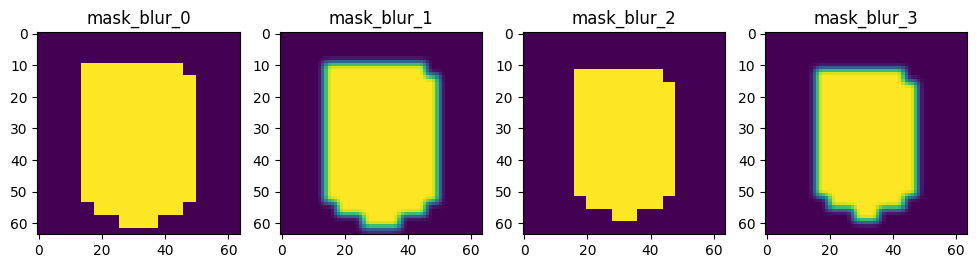

In [18]:
## to summarize:

mask = mask_viz
kernel_list=[(11,11),(9,9),(7,7),(5,5),(3,3)]
kernel_idxs=random.choices(range(len(kernel_list)), k=2)
# blend_ratio = blend_list[random.sample(range(len(blend_list)), 1)[0]]
# mask_blured = cv2.GaussianBlur(mask, kernel_list[0], 0)
mask_blured = cv2.GaussianBlur(mask, (5,5), 0)
mask_blured = mask_blured/(mask_blured.max())
pyplot.figure(figsize=(12,3))
pyplot.subplot(141)
pyplot.imshow(mask)
pyplot.title('mask_blur_0')
pyplot.subplot(142)
pyplot.imshow(mask_blured)
pyplot.title('mask_blur_1')
pyplot.subplot(143)
# print(mask_blured.max())
mask_blured[mask_blured<mask_blured.max()]=0
mask_blured[mask_blured>0]=1    ## step 1: this operation shrinks the binary mask, such that it will not change the face boundary.
pyplot.imshow(mask_blured)
pyplot.title('mask_blur_2')
pyplot.subplot(144)
mask_blured = cv2.GaussianBlur(mask_blured, (5,5), 0)   ## step 2: you can have the continuous change. 
pyplot.imshow(mask_blured)
pyplot.title('mask_blur_3')
pyplot.show()